# **Project: Amazon Product Recommendation System**

# **Marks: 40**
 **Aurther: Chiuhua Huang**

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [1]:
### If the library is not install, please uncomment the following line and run it
#!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [2]:
# import basic libraries for numeric computation and dataframe
import numpy as np 
import pandas as pd

# import ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import validation matrixs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# import alogrithm for recommendation system
from surprise import accuracy # To compute the accuracy of models
from surprise.reader import Reader # class is used to parse a file containing ratings, data should be in structure - user; item ; ratings
from surprise.dataset import Dataset # class for loading datasets
from surprise.model_selection import GridSearchCV # for tuning model hyperparameters
from surprise.model_selection import train_test_split # for splitting the data in train and test dataset
from surprise.model_selection import KFold # for implementing KFold cross-validation
from surprise.model_selection import cross_validate ## for cross-validation
## import similarity-based methods
from surprise.prediction_algorithms.knns import KNNBasic 
from surprise.prediction_algorithms.knns import KNNWithMeans 
from surprise.prediction_algorithms.knns import KNNWithZScore
from surprise.prediction_algorithms.knns import KNNBaseline
## import Basic methods
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.random_pred import NormalPredictor
## import matrix factorization based methods
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.prediction_algorithms.matrix_factorization import SVD 
from surprise.prediction_algorithms.matrix_factorization import NMF
## import some other methods to compare the result
from surprise.prediction_algorithms.slope_one import SlopeOne ## slope one is a kind of rating-based collaborative filtering.
from surprise.prediction_algorithms.co_clustering import CoClustering ## cluster-based

# ignore unnecessary warnings in the output
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict 

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [3]:
data = pd.read_csv("ratings_Electronics.csv", names = ['user_id', 'prod_id', 'rating', 'timestamp'], usecols=['user_id', 'prod_id', 'rating'])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [4]:
df = data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [5]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [6]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [7]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [8]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [9]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [10]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Observations**
- The data contains 65290 rows and 3 columns.

### **Data types**

In [11]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Observations**
- user_id and prod_id columns are objects.
- rating is in float. We should check if the rating is in discrete value or continous value.

### **Checking for missing values**

In [12]:
# Check for missing values present and provide observations
df_final.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations**
- There are no missing value in the data.

### **Summary Statistics**

In [13]:
# Summary statistics of 'rating' variable and provide observations
print(df_final.rating.unique())
df_final.rating.describe()

[5. 1. 3. 4. 2.]


count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations**
- The rating is between 1 to 5, and It is descrete.
- Over 50% of the data has rating at 5

### **Checking the rating distribution**

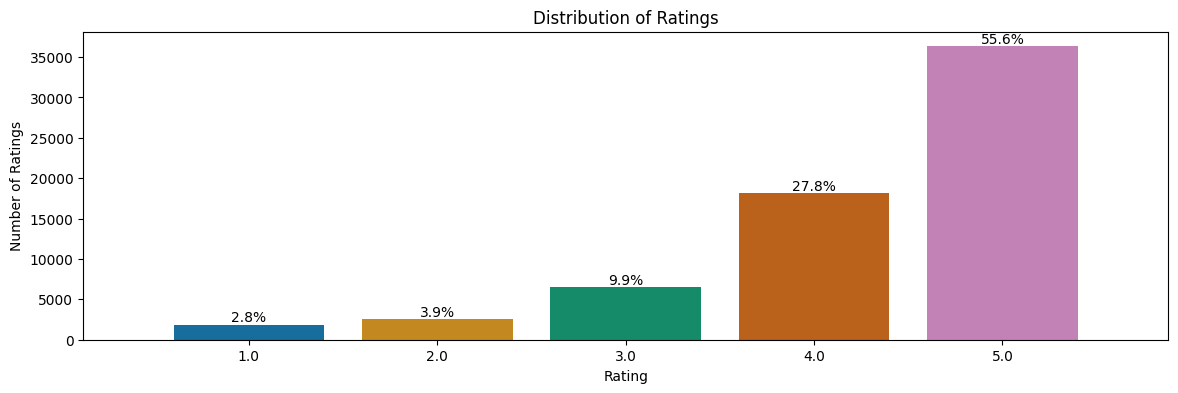

In [14]:
plt.figure(figsize = (14, 4))
ax = sns.countplot(x='rating', data=df_final, palette='colorblind', hue='rating', legend=False)

# get the total count of the type column
total = df_final['rating'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')

# add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Rating', ylabel='Number of Ratings', title='Distribution of Ratings')
plt.show()

**Observation**
- Over 83% of the ratings are rated in 4 or 5.
- We have few ratings in 1 or 2.

### **Checking the number of unique users and items in the dataset**

In [15]:
# Number of total rows in the data and number of unique user id and product id in the data
print("The number of unique user id is {user_id}. The number of unique product id is {item_id}.".format(user_id=len(df.user_id.unique()), item_id = len(df.prod_id.unique())))
print("Possible counts of ratings per numbers of unique users and product is {rate_P} ratings.".format(rate_P = len(df.user_id.unique())*len(df.prod_id.unique())))
print("The actual ratings in the data is {rate_A} ratings.".format(rate_A = df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()))

The number of unique user id is 1540. The number of unique product id is 48190.
Possible counts of ratings per numbers of unique users and product is 74212600 ratings.
The actual ratings in the data is 65290 ratings.


**Observations:**
- The number of unique user id is 1,540. The number of unique product id is 48,190.
- As per the number of unique users and products, there is a **possibility of 1540 * 48190 = 74,212,600 ratings** in the dataset. But **we only have 65,290 ratings**, i.e., not every user has rated every products in the dataset. So, we can build a recommendation system to recommend products to users which they have not interacted with.

### **Users with the most number of ratings**

In [16]:
# Top 10 users based on the number of ratings
df_final["user_id"].value_counts()[:10]

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

**Observations**
- The user ADLVFFE4VBT8 has the highest rating records with 295 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [17]:
# Calculate the average rating for each product 
average_rating = df.groupby("prod_id")["rating"].mean().rename("Average_Rating")
# Calculate the count of ratings for each product
count_rating = df.groupby("prod_id")["rating"].count().rename("Count_Rating")
# Create a dataframe with calculated average and count of ratings
final_rating = pd.merge(average_rating, count_rating, on = ["prod_id"])
# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values("Average_Rating", ascending= False, inplace= True)
# See the first five records of the "final_rating" dataset
final_rating.head()

,Average_Rating,Count_Rating
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [18]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data_rating, top_n, min_interactions):
    # Finding products with minimum number of interactions
    min_recommend = data_rating[data_rating["Count_Rating"]>= min_interactions].copy()
    # Sorting values with respect to average rating 
    min_recommend.sort_values("Average_Rating", ascending = False, inplace = True)
    # The top_n recommendation with respect to average rating
    return min_recommend.index[:top_n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [19]:
Recommend_1 = top_n_products(final_rating, 5, 50)
print("The top 5 products with 50 minimum interactions based on popularity is product",str(Recommend_1.values),".")

The top 5 products with 50 minimum interactions based on popularity is product ['B001TH7GUU' 'B003ES5ZUU' 'B0019EHU8G' 'B006W8U2MU' 'B000QUUFRW'] .


**Observations:**
- The top 5 products with 50 minimum interactions based on popularity is product ['B001TH7GUU' 'B003ES5ZUU' 'B0019EHU8G' 'B006W8U2MU' 'B000QUUFRW'].

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [20]:
Recommend_2 = top_n_products(final_rating, 5, 100)
print("The top 5 products with 100 minimum interactions based on popularity is product",str(Recommend_2.values),".")

The top 5 products with 100 minimum interactions based on popularity is product ['B003ES5ZUU' 'B000N99BBC' 'B002WE6D44' 'B007WTAJTO' 'B002V88HFE'] .


**Observations**
- The top 5 products with 100 minimum interactions based on popularity is product ['B003ES5ZUU' 'B000N99BBC' 'B002WE6D44' 'B007WTAJTO' 'B002V88HFE'] .

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a library, called `surprise`, to build the remaining models.

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [21]:
def precision_recall_at_k(model, testdf, algo_name, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testdf)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    rmse_score = accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    F_1_score = round((2*precision*recall)/(precision+recall), 3 )# Formula to compute the F-1 score

    print('F_1 score: ', F_1_score) # Command to print the F_1 score
    return pd.DataFrame([[rmse_score, precision, recall, F_1_score]], index = [algo_name], columns=["RMSE","Precision","Recall","F_1_score"])

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`df_final` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [22]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1,5))
# Loading the rating dataset
df_R = Dataset.load_from_df(df_final[["user_id","prod_id","rating"]], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(df_R, test_size = 0.2, random_state= 50)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [23]:
# Declaring the similarity options
sim_options = {'name':'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
knnbasic_user = precision_recall_at_k(algo_knn_user, testdf=testset, algo_name="KNNBasic_User_Baseline")

RMSE: 1.0250
Precision:  0.849
Recall:  0.855
F_1 score:  0.852


**Observations**
- We can observe that the baseline model has `RMSE=1.0250` on the test set.
- Intuition of Recall - We are getting a **recall of ~0.85**, which means out of **all the relevant products, 85% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.85**, which means **out of all the recommended products, 85% are relevant**.
- Here `F1 score of the baseline model is ~0.85`. It indicates that **mostly recommended products were relevant and relevant products were recommended**. We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [24]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Observations**
- The actual rating for this user-item pair is 5 and predicted rating is 3.33. We can observe that the predicted rating is not close to the real rating.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [25]:
# Find unique user_id where prod_id is not equal to "1400501466"
user_not_seen = df_final.loc[df_final["prod_id"]!="1400501466","user_id"].unique()
print("A total of {total} users who have not seen the product \"1400501466\":\n{not_seen_list}".format(total = len(user_not_seen), not_seen_list = [i for i in user_not_seen]))

A total of 1540 users who have not seen the product "1400501466":
['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', 'A1P4XD7IORSEFN', 'A341HCMGNZCBIT', 'A3HPCRD9RX351S', 'A1DQHS7MOVYYYA', 'ALUNVOQRXOZIA', 'A19N3S7CBSU6O7', 'A3G7BEJJCPD6DS', 'A2JXS1JII6SAUD', 'A1C82BC5GNABOA', 'A1VHCO8RQFIGQJ', 'A2Z9S2RQD542CP', 'A2QIC4G483SQQA', 'A3L6L5O89JTX2T', 'A1OGCPMSIVK7G4', 'A18HE80910BTZI', 'A3F9CBHV4OHFBS', 'A1T1YSCDW0PD25', 'ABVYGB2TKBO8F', 'A11ED8O95W2103', 'A3NCIN6TNL0MGA', 'ASHJAZC9OA9NS', 'A105TOJ6LTVMBG', 'A14JBDSWKPKTZA', 'A3QX0ERX4D03TF', 'A13WREJ05GMRA6', 'A3N8O68DOEQ2FE', 'A3J8A5L5AF5TX9', 'A2HRHF83I3NDGT', 'A1R3GN9MEJFXM3', 'A3963R7EPE3A7E', 'A2JOPUWVV0XQJ3', 'AAW7X3GRD8GY9', 'A3V8P0O224OBDB', 'AY6A8KPYCE6B0', 'A212MDP6K4VJS5', 'A28X0LT2100RL1', 'A1V3TRGWOMA8LC', 'A1NZLRAZJGD99W', 'A1522TN5FVJL0Y', 'A3UXW18DP4WSD6', 'A3CW0ZLUO5X2B1', 'A3TBMGNSEQBWIL', 'AEZJTA4KDIWY8', 'A22CW0ZHY3NJH8', 'A2V7EO331SFUF6', 'A3977M5S0GIG5H', 'A1F1A0QQP2XVH5', 'A231WM2Z2JL0U3', 'A2JWF9IG8PJAOA', 'A3L

In [26]:
user_ID_check = "A34BZM6S9L7QI4"
if user_ID_check in user_not_seen:
    print(f"User {user_ID_check} has not seen the product \"1400501466\".")
else:
     print(f"User {user_ID_check} has seen the product \"1400501466\".")

User A34BZM6S9L7QI4 has not seen the product "1400501466".


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with product Id "1400501466"** as this user Id is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [27]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 2.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=2.0, details={'actual_k': 2, 'was_impossible': False})

**Observation**
- User "A34BZM6S9L7QI4" might give a **rating at 2** on the product "1400501466".

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [28]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20,25,30,35,40], 'min_k': [1,2,3,4,5,6,7,8,9,10],
              'sim_options': {'name': ['msd', 'cosine','pearson','pearson_baseline'],
                              'user_based': [True]},
                'random_state' : [1]
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(df_R)
# Best RMSE score
print("The best RMSE score is:",gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print("The combination of parameters that gave the best RMSE score are:",gs.best_params['rmse'])

The best RMSE score is: 0.9680818580610363
The combination of parameters that gave the best RMSE score are: {'k': 35, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}, 'random_state': 1}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [29]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_user_opt = KNNBasic(sim_options=sim_options, k=40, min_k=4, verbose=False, random_state = 1)
# Training the algorithm on the trainset
algo_knn_user_opt.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
knnbasic_user_opt = precision_recall_at_k(algo_knn_user_opt, testdf=testset, algo_name="KNNBasic_User_Opt", k=10)

RMSE: 0.9662
Precision:  0.847
Recall:  0.89
F_1 score:  0.868


In [30]:
# compare baseline and tuning scores
pd.concat([knnbasic_user, knnbasic_user_opt])

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Baseline,1.025023,0.849,0.855,0.852
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868


**Observations**
- We can observe that the tuning model has `RMSE=0.9662` on the test set. It gets better compare to the baseline model.
- Intuition of Recall - We are getting a **recall of ~0.89**, which means out of **all the relevant products, 89% are recommended**. The Recall score increases.
- Intuition of Precision - We are getting a **precision of ~ 0.85**, which means **out of all the recommended products, 84% are relevant**. The rate has slightly decreases.
- Here `F_1 score of the Tuning model is ~0.87`. It indicates that **mostly recommended products were relevant and relevant products were recommended**. Overall that the preformance of the alogorithm gets better after the hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [31]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
algo_knn_user_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knn_user_opt.predict("A34BZM6S9L7QI4","1400501466", verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29663807627508, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
- User "A3LDPF5FMB782Z" was predicted to rate product "1400501466" at 3.33, but the actual rating should be 5. This remain the same as the baseline algorithm.
- User "A34BZM6S9L7QI4" was predicted to rate product "1400501466" at ~4.3. This is very different from the baseline algorithm. Since the overall preformance on the optimization model is better than the baseline model, we can say that 4.3 might be more closer to the real customer preference.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [33]:
# 0 is the inner id of the above user
inner_id = 0
inner_neighbor = algo_knn_user_opt.get_neighbors(inner_id, k=5)
print("The inner_id is {inn_id}, which represents user id:{raw_id}.".format(inn_id = inner_id, raw_id = trainset.to_raw_uid(inner_id)))
print("The 5 most similar users compare to inner_id {inn_id} are:".format(inn_id = inner_id))
for i in inner_neighbor:
    print("  inner_id:{inner}, user_id:{raw}".format(inner = i, raw = trainset.to_raw_uid(i)))

The inner_id is 0, which represents user id:A124WZCUIH2T7W.
The 5 most similar users compare to inner_id 0 are:
  inner_id:7, user_id:AVPNQUVZWMDSX
  inner_id:8, user_id:AIBRTGBN07D6A
  inner_id:9, user_id:AOEDWQLH2WKKW
  inner_id:14, user_id:A6FIAB28IS79
  inner_id:15, user_id:A1TQBAHI3M4ZBQ


**Observation**
- The 5 most similar users to the user with inner id 0 is [7, 8, 9, 14, 15].
- The 5 most similar users to user "A124WZCUIH2T7W" is ["A1TQBAHI3M4ZBQ", "A2MR696ZU17F12", "A186697K4XKXQL", "A17HMM1M7T9PJ1", "A2UEB48LAWFUCW"].

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [34]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [35]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommend_Knn_Basic_user = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, algo_knn_user_opt)

In [36]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommend_Knn_Basic_user, columns = ['prod_id','predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000068O34,5
2,B00006I5J7,5
3,B00006IW1X,5
4,B00006RVPW,5


**Observation**
- The top five recommended products for user "A3LDPF5FMB782Z" are "B000067RT6", "B000068O34", "B00006I5J7", B00006IW1X", "B00006RVPW".
- All of which have a predicted rating of 5.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [37]:
# Declaring the similarity options
sim_options = {'name':'cosine', 'user_based':False}
# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
algo_knn_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
knnbasic_item = precision_recall_at_k(algo_knn_item, algo_name="KNNBasic_Item_Baseline", testdf=testset)

RMSE: 1.0200
Precision:  0.829
Recall:  0.842
F_1 score:  0.835


**Observations**
- We can observe that the baseline model has `RMSE=1.02` on the test set.
- Intuition of Recall - We are getting a **recall of ~0.84**, which means out of **all the relevant users, 84% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.83**, which means **out of all the recommended users, 83% are relevant**.
- Here `F_1 score of the baseline model is ~0.84`. It indicates that **mostly recommended users were relevant and relevant users were recommended**. We can try to improve the performance by using `GridSearchCV` to tune different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [38]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict("A3LDPF5FMB782Z","1400501466",r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.43   {'actual_k': 23, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.434782608695652, details={'actual_k': 23, 'was_impossible': False})

**Observation:**
- We can observe that user "A3LDPF5FMB782Z" has an actual rating at 5 on product "1400501466", the algorithm predicts the user will have a `rating at 4.43`. This is close to 5 and better than the user-based method. However, it still need a little improvement.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [39]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 2, 'was_impossible': False})

**Observation:**
- The predicted rating on product "1400501466" for user "A34BZM6S9L7QI4" is 4.0.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [40]:
# Setting up parameter grid to tune the hyperparameters
param_grid =  {'k': [10, 20, 30], 'min_k': [3, 6, 9],
               'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]},
               'random_state': [1]}
# Performing 3-fold cross validation to tune the hyperparameters
gs_item = GridSearchCV(KNNBasic, param_grid=param_grid, measures=['rmse'], cv =3, n_jobs=-1)
# Fitting the data
gs_item.fit(df_R)
# Find the best RMSE score
print(gs_item.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs_item.best_params['rmse'])

0.9745462189582872
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}, 'random_state': 1}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [41]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
algo_knn_item_opt = KNNBasic(k=30,min_k=6,sim_options=sim_options, random_state = 1, verbose= False)
# Training the algorithm on the trainset
algo_knn_item_opt.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
knnbasic_item_opt = precision_recall_at_k(algo_knn_item_opt, algo_name = "KNNBasic_Item_Opt",testdf=testset)

RMSE: 0.9784
Precision:  0.834
Recall:  0.886
F_1 score:  0.859


In [42]:
# compare baseline and tuning score
pd.concat([knnbasic_item,knnbasic_item_opt])

,RMSE,Precision,Recall,F_1_score
KNNBasic_Item_Baseline,1.019979,0.829,0.842,0.835
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859


**Observations**
- We can observe that the tuning model has `RMSE=0.9784` on the test set. It gets better compare to the baseline model.
- Intuition of Recall - We are getting a **recall of ~0.89**, which means out of **all the relevant users, 89% are recommended**. The value increases compare to the baseline model.
- Intuition of Precision - We are getting a **precision of ~ 0.83**, which means **out of all the recommended users, 83% are relevant**. The increases slightly compare to the baseline model.
- Here `F_1 score of the tuning model is ~0.86`. It indicates that **mostly recommended users were relevant and relevant users were recommended**. We can say that the preformance on the model is better after tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [43]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_knn_item_opt.predict("A3LDPF5FMB782Z","1400501466",r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.73   {'actual_k': 23, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.725146198830409, details={'actual_k': 23, 'was_impossible': False})

In [44]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knn_item_opt.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29663807627508, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**
- User "A3LDPF5FMB782Z" was predicted to rate product "1400501466" at 4.73, where the actual rating should be 5. The predicted rating is much closer to the actual value.
- User "A34BZM6S9L7QI4" was predicted to rate product "1400501466" at ~4.3. This is higher than the baseline method. We can tell that based on the algorithm, the user might be interested in the product.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [45]:
inner_id = 0
inner_neighbor = algo_knn_item_opt.get_neighbors(inner_id, k=5)
print("The inner_id is {inn_id}, which represents product id:{raw_id}.".format(inn_id = inner_id, raw_id = trainset.to_raw_iid(inner_id)))
print("The 5 most similar products compare to inner_id {inn_id} are:".format(inn_id = inner_id))
for i in inner_neighbor:
    print("  inner_id:{inner}, prod_id:{raw}".format(inner = i, raw = trainset.to_raw_iid(i)))

The inner_id is 0, which represents product id:B003SQEAY0.
The 5 most similar products compare to inner_id 0 are:
  inner_id:15, prod_id:B0002L5R78
  inner_id:62, prod_id:B0019EHU8G
  inner_id:120, prod_id:B000AZ57M6
  inner_id:143, prod_id:B0002Y5WXE
  inner_id:205, prod_id:B008ABOJKS


**Observation**
- The 5 most similar products to the product with internal id 0 are [15, 62, 120, 143, 205].
- The 5 most similar products to product "B003SQEAY0" are ["B0002L5R78", "B0019EHU8G", "B000AZ57M6", "B0002Y5WXE", "B008ABOJKS"].

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [46]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommend_Knn_Basic_item = get_recommendations(df_final, "A1A5KUIIIHFF4U",5, algo_knn_item_opt)

In [47]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommend_Knn_Basic_item, columns=['prod_Id', 'predicted_ratings'])

,prod_Id,predicted_ratings
0,B002QEBMAK,4.872340
1,B001MSU1FS,4.482759
2,1400532655,4.296638
3,1400599997,4.296638
4,9983891212,4.296638


**Observation**
- The top five recommended products for user "A1A5KUIIIHFF4U" are "B002QEBMAK", "B001MSU1FS", "1400532655", 1400599997", "9983891212".

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [48]:
# Using SVD matrix factorization. Use random_state = 1
algo_svd = SVD(random_state=1)
# Training the algorithm on the trainset
algo_svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
svd_base = precision_recall_at_k(algo_svd,algo_name="SVD_Baseline", testdf=testset)

RMSE: 0.9054
Precision:  0.845
Recall:  0.88
F_1 score:  0.862


In [49]:
# compare with other method
pd.concat([svd_base,knnbasic_item,knnbasic_item_opt,knnbasic_user,knnbasic_user_opt]).sort_values("RMSE")

,RMSE,Precision,Recall,F_1_score
SVD_Baseline,0.905446,0.845,0.880,0.862
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
KNNBasic_Item_Baseline,1.019979,0.829,0.842,0.835
KNNBasic_User_Baseline,1.025023,0.849,0.855,0.852


**Observations:**
- We observe that the `baseline F_1 score` for the matrix factorization model on the test set is higher in comparison to the F_1 score for the user-user similarity-based recommendation system and lower in comparison to the optimized user-user similarity-based recommendation system.
- The result for SVD is better than both baseline and optimized item-item similarity-based recommendation systems.
- The `RMSE` of the Baseline SVD is the lowest among five methods.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [50]:
# Making prediction
algo_svd.predict("A3LDPF5FMB782Z","1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.24   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.240489993101994, details={'was_impossible': False})

**Observartion**
- The predicted rating is 4.24 while the real rating is 5.00. It is close to the actual rating, but still need improvements.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [51]:
# Making prediction
algo_svd.predict("A34BZM6S9L7QI4","1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.24   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.237475727588978, details={'was_impossible': False})

**Observation**
- The predicted rating is 4.24, based on the algorithm, the user is likely to give the product a high rating.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [52]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10,15,20,25,30], 'lr_all': [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.1],
              'reg_all':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 'random_state':[1]}
# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv = 3, n_jobs=-1)
# Fitting data
gs_svd.fit(df_R)
# Best RMSE score
print(gs_svd.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

0.897762538538529
{'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.3, 'random_state': 1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
algo_svd_opt = SVD(n_epochs=30, lr_all=0.007, reg_all=0.3,random_state = 1)
# Train the algorithm on the trainset
algo_svd_opt.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
svd_opt = precision_recall_at_k(algo_svd_opt, algo_name = "SVD_Opt", testdf = testset)

RMSE: 0.8964
Precision:  0.849
Recall:  0.882
F_1 score:  0.865


In [54]:
# compare baseline and tuning score
pd.concat([svd_opt, svd_base, knnbasic_user_opt])

,RMSE,Precision,Recall,F_1_score
SVD_Opt,0.896444,0.849,0.882,0.865
SVD_Baseline,0.905446,0.845,0.880,0.862
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868


**Observation**
- After tuning hyperparameters, the model preformance increased on each perspective slightly. However the F_1_score is still lower than the User-Based Similarity optimization model.	

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [55]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_svd_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0425719584931885, details={'was_impossible': False})

In [56]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_svd_opt.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.02   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.015397297497269, details={'was_impossible': False})

**Observation**
- The prediction of svd after hyperparameter tuning of userId "A3LDPF5FMB782Z" and productId "1400501466" is 4.04. The rating is further from the real rating (=5) compare to the predicted value before tuning(=4.24).
- The prediction of svd after hyperparameter tuning of userId "A34BZM6S9L7QI4" and productId "1400501466" is 4.02. It is lower than the predicted rating value before tuning.
- The prediction accuracy does not seem to improve much after tuning.

In [57]:
print(algo_knn_user.predict("A3LDPF5FMB782Z","1400501466", r_ui=5).est,
      algo_knn_user_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5).est,
      algo_knn_item.predict("A3LDPF5FMB782Z","1400501466", r_ui=5).est,
      algo_knn_item_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5).est,
      algo_svd.predict("A3LDPF5FMB782Z","1400501466", r_ui=5).est,
      algo_svd_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5).est, sep = "\n")

3.3333333333333335
3.3333333333333335
4.434782608695652
4.725146198830409
4.240489993101994
4.0425719584931885


In [58]:
algo_knn_user.predict("A3LDPF5FMB782Z","1400501466", r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

## Try other methods in the surprise library to compare the result

In [59]:
# First, we combine the results of the methods preformed above for comparasion.
score_result = pd.concat([knnbasic_item,knnbasic_item_opt,knnbasic_user,knnbasic_user_opt,svd_base,svd_opt]).sort_values("F_1_score", ascending= False)

**We benchmark differnent methods with cross validation to see which has the lowest RMSE**

In [60]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBaseline(), KNNBasic(), KNNWithZScore(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, df_R, measures=['RMSE'], cv=3, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp._append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.906181,0.268858,0.054488
CoClustering,0.969803,0.612166,0.064171
KNNBaseline,0.986498,0.084731,0.230916
KNNWithZScore,0.989730,0.074568,0.213911
KNNBasic,1.048882,0.041112,0.222781


**Observation**
- We can observe that `Colclustering`, `KNNBaseline`, alogorithm have lower RMSE. We will try these methods to see if there is better F1 score.

### **CoClustering Baseline model**

In [61]:
# Build a CoClustering model. Use random_state=1
algo_coclustering = CoClustering(n_cltr_u=5, n_cltr_i=10, n_epochs=20, random_state=1, verbose=False)
# Train the algorithm on the trainset
algo_coclustering.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
cocluster = precision_recall_at_k(algo_coclustering, algo_name = "CoClustering", testdf = testset)

RMSE: 1.0252
Precision:  0.849
Recall:  0.818
F_1 score:  0.833


In [62]:
# compare with other method, we will only take optimized alogorithm here to compare.
pd.concat([svd_opt,knnbasic_item_opt,knnbasic_user_opt,cocluster]).sort_values("F_1_score", ascending=False)

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
SVD_Opt,0.896444,0.849,0.882,0.865
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
CoClustering,1.025244,0.849,0.818,0.833


**Observations:**
- We observe that the `baseline F_1 score` for the CoClustering model on the test set is **lower** in comparison to the F_1 score for the user-user based KNNBasic method, the item-item based KNNBasic Method, and the SVD methods.
- The `RMSE` of the Baseline Coclustering is the highest among the four methods.
- The methods doesn't seem to have better preformance, let's try hyperparameter tuning to see if there is improvements.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [63]:
# Making prediction
algo_coclustering.predict("A3LDPF5FMB782Z","1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.71   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.714997247787327, details={'was_impossible': False})

**Observartion**
- The predicted rating is 3.71 while the real rating is 5.00. It is not close to the real rating.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [64]:
# Making prediction
algo_coclustering.predict("A34BZM6S9L7QI4","1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.98   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.9842497661073732, details={'was_impossible': False})

**Observation**
- The predicted rating is 3.98.

### **Improving CoClustering based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_cltr_u**: The number of user clusters. Default is 3.
- **n_cltr_i**: The number of item clusters. Default is 3.
- **n_epochs**: The number of iteration of the optimization loop. Default is 20.

In [65]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3,5,7,9,10,11,12,15,20], 'n_cltr_i': [5,6,7,8,9,10,11,12,15,18,25,50],
              'n_epochs':[10,20,30,40,50,60], 'random_state':[1]}
# Performing 3-fold gridsearch cross-validation
gs_coclustering = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv = 3, n_jobs=-1)
# Fitting data
gs_coclustering.fit(df_R)
# Best RMSE score
print(gs_coclustering.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_coclustering.best_params['rmse'])

0.983741134985773
{'n_cltr_u': 3, 'n_cltr_i': 5, 'n_epochs': 10, 'random_state': 1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [66]:
# Build the optimized CoClustering model using optimal hyperparameter search. Use random_state=1
algo_coclustering_opt = CoClustering(n_cltr_u=3, n_cltr_i=5, n_epochs=10, random_state=1, verbose=False)
# Train the algorithm on the trainset
algo_coclustering_opt.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
cocluster_opt = precision_recall_at_k(algo_coclustering_opt, algo_name = "CoClustering_Opt", testdf = testset)

RMSE: 0.9733
Precision:  0.849
Recall:  0.821
F_1 score:  0.835


In [67]:
# compare baseline and optimized model
pd.concat([svd_opt, knnbasic_item_opt, knnbasic_user_opt, cocluster, cocluster_opt]).sort_values("F_1_score", ascending=False)

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
SVD_Opt,0.896444,0.849,0.882,0.865
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
CoClustering_Opt,0.973339,0.849,0.821,0.835
CoClustering,1.025244,0.849,0.818,0.833


**Observation**
- After tuning hyperparameters, the model preformance increased compare to the baseline model. However the F_1_score is still the lowest compare to other methods.	

In [68]:
# Use algo_coclustering_opt model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_coclustering_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.61   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.609410152354525, details={'was_impossible': False})

In [69]:
# Use algo_coclustering_opt model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_coclustering_opt.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.94   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.9420776584942923, details={'was_impossible': False})

**Observation**
- After tuning hyperparameters, the prediction doesn't seem to improve much.	

### **KNNBaseline Item-Based Baseline model**

In [70]:
# Declaring the similarity options
sim_options = {'name':'cosine', 'user_based':False}
# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knnBaseline_item = KNNBaseline(sim_options=sim_options, verbose=False, random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
algo_knnBaseline_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
knnbaseline_item = precision_recall_at_k(algo_knnBaseline_item, algo_name="KNNBaseline_Item_Baseline", testdf=testset)

RMSE: 0.9612
Precision:  0.842
Recall:  0.844
F_1 score:  0.843


In [71]:
# compare with other method, we will only take optimized alogorithm here to compare.
pd.concat([svd_opt,knnbasic_item_opt,knnbasic_user_opt,cocluster_opt,knnbaseline_item]).sort_values("F_1_score", ascending=False)

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
SVD_Opt,0.896444,0.849,0.882,0.865
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
KNNBaseline_Item_Baseline,0.961226,0.842,0.844,0.843
CoClustering_Opt,0.973339,0.849,0.821,0.835


**Observations:**
- We observe that the `baseline F_1 score` for the KNNBaseline item-based model on the test set is **lower** in comparison to the F_1 score for the user-user based KNNBasic method, the item-item based KNNBasic Method, and the SVD methods. The F_1_score is higher than CoClustering model.
- The `RMSE` of the Baseline KNNBaseline Item-based model is lower than CoClustering model.
- The methods seem to have better preformance than CoClustering model, let's try hyperparameter tuning to get a better model.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [72]:
# Making prediction
algo_knnBaseline_item.predict("A3LDPF5FMB782Z","1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.06   {'actual_k': 23, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.061826159482693, details={'actual_k': 23, 'was_impossible': False})

**Observartion**
- The predicted rating is 4.06 while the real rating is 5.00.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [73]:
# Making prediction
algo_knnBaseline_item.predict("A34BZM6S9L7QI4","1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.66   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.6588835997902605, details={'actual_k': 2, 'was_impossible': False})

**Observation**
- The predicted rating is 3.66.

### **Improving Item-based with KNNBaseline recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBaseline` algorithm. Let's try to understand some of the hyperparameters of the KNNBaseline algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline
- **bsl_options** (dict) - A dictionary of options for the baseline estimates computation. And there are two methods available in surprise - 
    - sgd
    - als (default)

In [74]:
# Set the parameter space to tune
param_grid = {'k': [10,20,30,40,50,60], 'min_k': [2,3,4,5,6,7,8,9,10],
              'sim_options':{'name':['cosine','msd','pearson','pearson_baseline'], 'user_based':[False]}, 'bsl_options':{'method':['sgd','als']},'random_state':[1]}
# Performing 3-fold gridsearch cross-validation
gs_knnbaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv = 3, n_jobs=-1)
# Fitting data
gs_knnbaseline.fit(df_R)
# Best RMSE score
print(gs_knnbaseline.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_knnbaseline.best_params['rmse'])

0.8997758709671212
{'k': 20, 'min_k': 9, 'sim_options': {'name': 'pearson', 'user_based': False}, 'bsl_options': {'method': 'sgd'}, 'random_state': 1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [75]:
# Build the optimized KNNBaseline item-based model using optimal hyperparameter search. Use random_state=1
algo_knnBaseline_item_opt = KNNBaseline(k = 30, min_k = 10, sim_options = {'name':'pearson', 'user_based':False}, bsl_options={'method':'sgd'}, random_state=1, verbose=False)
# Train the algorithm on the trainset
algo_knnBaseline_item_opt.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
knnbaseline_item_opt = precision_recall_at_k(algo_knnBaseline_item_opt, algo_name = "KNNBaseline_Item_Opt", testdf = testset)

RMSE: 0.8982
Precision:  0.847
Recall:  0.877
F_1 score:  0.862


In [76]:
# compare baseline and optimized model
pd.concat([svd_opt, knnbasic_item_opt, knnbasic_user_opt, cocluster_opt, knnbaseline_item, knnbaseline_item_opt]).sort_values("F_1_score", ascending=False)

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
SVD_Opt,0.896444,0.849,0.882,0.865
KNNBaseline_Item_Opt,0.898184,0.847,0.877,0.862
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
KNNBaseline_Item_Baseline,0.961226,0.842,0.844,0.843
CoClustering_Opt,0.973339,0.849,0.821,0.835


**Observation**
- After tuning hyperparameters, the model preformance increased compare to the baseline model. The F_1_score is now better than the KNNBasic Item-based model.

In [77]:
# Use algo_knnBaseline_opt model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_knnBaseline_item_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.99   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.991405022771393, details={'actual_k': 1, 'was_impossible': False})

In [78]:
# Use algo_knnBaseline_opt model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knnBaseline_item_opt.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'actual_k': 0, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.165549849423379, details={'actual_k': 0, 'was_impossible': False})

**Observation**
- After tuning hyperparameters, the prediction on user: A3LDPF5FMB782Z gets further from the actual value.
- The prediction on user: A34BZM6S9L7QI4 is 4.17.

### **KNNBaseline User-Based Baseline model**

In [79]:
# Declaring the similarity options
sim_options = {'name':'cosine', 'user_based':True}
# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knnBaseline_user = KNNBaseline(sim_options=sim_options, verbose=False, random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
algo_knnBaseline_user.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
knnbaseline_user = precision_recall_at_k(algo_knnBaseline_user, algo_name="KNNBaseline_User", testdf=testset)

RMSE: 0.9701
Precision:  0.851
Recall:  0.85
F_1 score:  0.85


In [80]:
# compare with other method, we will only take optimized alogorithm here to compare.
pd.concat([svd_opt,knnbasic_item_opt,knnbasic_user_opt,cocluster_opt,knnbaseline_item_opt, knnbaseline_user]).sort_values("F_1_score", ascending=False)

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
SVD_Opt,0.896444,0.849,0.882,0.865
KNNBaseline_Item_Opt,0.898184,0.847,0.877,0.862
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
KNNBaseline_User,0.970124,0.851,0.850,0.850
CoClustering_Opt,0.973339,0.849,0.821,0.835


**Observations:**
- We observe that the `baseline F_1 score` for the KNNBaseline user-based model on the test set is **lower** in comparison to the F_1 score for the user-user based KNNBasic method, the item-item based KNNBasic Method, the item-item based KNNBaseline method, and the SVD method.
- The `RMSE` of the Baseline method is the lower than the CoClustering model.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [81]:
# Making prediction
algo_knnBaseline_user.predict("A3LDPF5FMB782Z","1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.47   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4680443028990866, details={'actual_k': 6, 'was_impossible': False})

**Observartion**
- The predicted rating is 4.06 while the real rating is 5.00.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [82]:
# Making prediction
algo_knnBaseline_user.predict("A34BZM6S9L7QI4","1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 2.47   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=2.467860225450111, details={'actual_k': 2, 'was_impossible': False})

**Observation**
- The predicted rating is 3.66.

### **Improving Item-based with KNNBaseline recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBaseline` algorithm. Let's try to understand some of the hyperparameters of the KNNBaseline algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline
- **bsl_options** (dict) - A dictionary of options for the baseline estimates computation. And there are two methods available in surprise - 
    - sgd
    - als (default)

In [83]:
# Set the parameter space to tune
param_grid = {'k': [10,20,30,40,50,60], 'min_k': [2,3,4,5,6,7,8,9,10],
              'sim_options':{'name':['cosine','msd','pearson','pearson_baseline'], 'user_based':[True]}, 'bsl_options':{'method':['sgd','als']},'random_state':[1]}
# Performing 3-fold gridsearch cross-validation
gs_knnbaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv = 3, n_jobs=-1)
# Fitting data
gs_knnbaseline.fit(df_R)
# Best RMSE score
print(gs_knnbaseline.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_knnbaseline.best_params['rmse'])

0.8994138138164235
{'k': 20, 'min_k': 10, 'sim_options': {'name': 'pearson', 'user_based': True}, 'bsl_options': {'method': 'sgd'}, 'random_state': 1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [84]:
# Build the optimized KNNBaseline item-based model using optimal hyperparameter search. Use random_state=1
algo_knnBaseline_user_opt = KNNBaseline(k = 20, min_k = 10, sim_options = {'name':'pearson', 'user_based':True}, bsl_options={'method':'sgd'}, random_state=1, verbose=False)
# Train the algorithm on the trainset
algo_knnBaseline_user_opt.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
knnbaseline_user_opt = precision_recall_at_k(algo_knnBaseline_user_opt, algo_name = "KNNBaseline_User_Opt", testdf = testset)

RMSE: 0.8983
Precision:  0.847
Recall:  0.877
F_1 score:  0.862


In [85]:
# compare baseline and optimized model
pd.concat([svd_opt, knnbasic_item_opt, knnbasic_user_opt, cocluster_opt, knnbaseline_item_opt, knnbaseline_user_opt, knnbaseline_user]).sort_values("F_1_score", ascending=False)

,RMSE,Precision,Recall,F_1_score
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868
SVD_Opt,0.896444,0.849,0.882,0.865
KNNBaseline_Item_Opt,0.898184,0.847,0.877,0.862
KNNBaseline_User_Opt,0.898349,0.847,0.877,0.862
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859
KNNBaseline_User,0.970124,0.851,0.850,0.850
CoClustering_Opt,0.973339,0.849,0.821,0.835


**Observation**
- After tuning hyperparameters, the model preformance increased compare to the baseline model. The F_1_score is now better than the KNNBasic Item-based model, but lower than the KNNBaseline Item-based model.

In [86]:
# Use algo_knnBaseline_opt model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_knnBaseline_user_opt.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.99   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.991405022771393, details={'actual_k': 1, 'was_impossible': False})

In [87]:
# Use algo_knnBaseline_opt model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knnBaseline_user_opt.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'actual_k': 0, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.165549849423379, details={'actual_k': 0, 'was_impossible': False})

**Observation**
- After tuning hyperparameters, the prediction on user: A3LDPF5FMB782Z gets closer to the actual value.
- The prediction on user: A34BZM6S9L7QI4 is 4.17.

### **Comparison between models**
- Score Value
- Prediction results

In [88]:
# Score value
score_result = pd.concat([score_result, cocluster,cocluster_opt, knnbaseline_item, knnbaseline_item_opt, knnbaseline_user, knnbaseline_user_opt]).sort_values("F_1_score", ascending=False)

In [89]:
# Predicted Value for productID "1400501466"
prediction_result = pd.DataFrame(index = score_result.index)
algo_list = [algo_knn_user_opt, algo_svd_opt, algo_svd, algo_knnBaseline_item_opt, algo_knnBaseline_user_opt, algo_knn_item_opt, algo_knn_user, algo_knnBaseline_user, algo_knnBaseline_item, algo_knn_item, algo_coclustering,algo_coclustering_opt]
est1 = []
est2 = []
for algo in algo_list:
    est1.append(algo.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=False).est)
    est2.append(algo.predict("A34BZM6S9L7QI4","1400501466", r_ui=5, verbose=False).est)
prediction_result["prediction_A3LDPF5FMB782Z(value=5)"] = est1
prediction_result["prediction_A34BZM6S9L7QI4(value=unknown)"] = est2

In [91]:
# comparison between different model
pd.concat([score_result, prediction_result], axis=1)

,RMSE,Precision,Recall,F_1_score,prediction_A3LDPF5FMB782Z(value=5),prediction_A34BZM6S9L7QI4(value=unknown)
KNNBasic_User_Opt,0.966155,0.847,0.890,0.868,3.333333,4.296638
SVD_Opt,0.896444,0.849,0.882,0.865,4.042572,4.015397
SVD_Baseline,0.905446,0.845,0.880,0.862,4.240490,4.237476
KNNBaseline_Item_Opt,0.898184,0.847,0.877,0.862,3.991405,4.165550
KNNBaseline_User_Opt,0.898349,0.847,0.877,0.862,3.991405,4.165550
KNNBasic_Item_Opt,0.978362,0.834,0.886,0.859,4.725146,4.296638
KNNBasic_User_Baseline,1.025023,0.849,0.855,0.852,3.333333,2.000000
KNNBaseline_User,0.970124,0.851,0.850,0.850,3.468044,2.467860
KNNBaseline_Item_Baseline,0.961226,0.842,0.844,0.843,4.061826,3.658884
KNNBasic_Item_Baseline,1.019979,0.829,0.842,0.835,4.434783,4.000000


**Obsevations**
- User-based KNN recommendation system has the highest F_1_score. Followed by SVD, item-based KNNBaseline, user-based KNNBaseline.
- SVD recommendation system has the lowest RMSE. Followed by item-based KNNBaseline, user-based KNNBaseline, user-based KNN.

### **Conclusion and Recommendations**

1. User-based KNN recommendation system has the highest F_1_score, but we can see that the prediction on productID "1400501466" for userID "A3LDPF5FMB782Z" is not close to the actual rating value. In this case item-based KNN recommendation system might be a better choice for recommendatoin model, since it has relatively low RMSE, high F_1_score, and better prediction value.
2. For further improvements, we can try other methods of recommendation system, knnwithmeans or svdpp etc.. We can also try to use some hybrid model to build a better recommendation model.
3.  One way to hybrid is to apply the User-based KNN, SVD, item-based KNNbasedline and user-based KNNBaseline model to bulid a recommendation model. We can compare the prediction of the four model and get the average rating of them. It might generate a more accurate recommendation system.